# Print user and problem rating history

** enter user handle in "handle" variable" **

In [ ]:
handle = 'I_love_Tanya_Romanova'

Run the rest of the cells to generate f 

In [1]:
%matplotlib inline
%load_ext rpy2.ipython

import requests
import pandas as pd
import numpy as np
from datetime import datetime

from os import listdir

maxcount = '100000000'
url = 'http://codeforces.com/api/user.status?handle=' + handle + '&from=1&count=' + maxcount

r = requests.get(url).json()['result']

arr = []
keys = ['testset', 'passedTestCount', 'author', 'relativeTimeSeconds', 
        'language', 'memoryBytes', 'timeMilliseconds', 'problem_name', 'problem_index',
        'problem_tags', 'points', 'contestID', 'verdict', 'id', 'participantType', 'startTimeSeconds']

for rr in r:
#    try:
    temp = dict.fromkeys(keys)
    temp['author'] = rr['author']['members'][0]['handle']
    temp['startTimeSeconds'] = rr['creationTimeSeconds']
    if 'startTimeSeconds' not in rr['author']:
        temp['participantType'] = 'GYM'
    else:
    #    temp['startTimeSeconds'] = rr['author']['startTimeSeconds']
        temp['participantType'] = rr['author']['participantType']
    temp['id'] = rr['id']
    temp['verdict'] = rr['verdict']
    temp['contestID'] = rr['contestId']
    if 'points' not in rr['problem']:
        temp['points'] = 0
    else:
        temp['points'] = rr['problem']['points']
    temp['problem_tags'] = rr['problem']['tags']
    temp['problem_index'] = rr['problem']['index']
    temp['problem_name'] = rr['problem']['name']
    temp['timeMilliseconds'] = rr['timeConsumedMillis']
    temp['memoryBytes'] = rr['memoryConsumedBytes']
    temp['language'] = rr['programmingLanguage']
    temp['relativeTimeSeconds'] = rr['relativeTimeSeconds']
    temp['passedTestCount'] = rr['passedTestCount']
    temp['testset'] = rr['testset']

    arr.append(temp)
    
hact = pd.DataFrame.from_dict(arr)

df_problems = pd.DataFrame.from_csv('problem_ratings.csv', index_col=None)
df_problems.index = [df_problems['contestID'], df_problems['problemID']]

url = 'http://codeforces.com/api/user.rating?handle=' + handle

r = requests.get(url).json()['result']
rating_history = pd.DataFrame.from_dict(r)

df_success = hact
df_success.index = [ df_success.contestID, df_success.problem_index ]

problem_ratings = []
keyerrors = []
for cid, pid in zip(df_success.contestID, df_success.problem_index):
    try:
        problem_ratings.append(df_problems.loc[cid,pid].problemRating)
    except KeyError:
        keyerrors.append([cid, pid])
        problem_ratings.append(-1)

df_success.loc[:,'problem_rating'] = problem_ratings

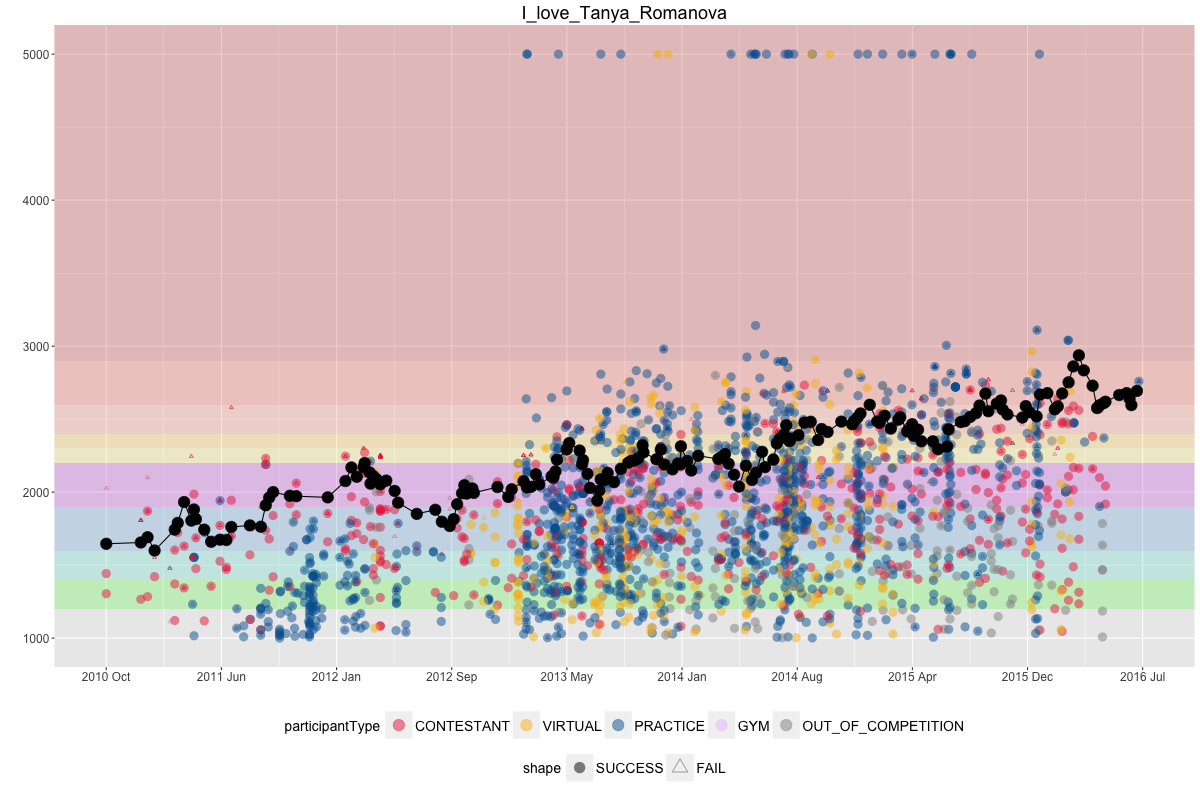

In [9]:
%%R -i df_success -w 1200 -h 800 -u px -i rating_history -i handle
library(ggplot2)
library(ggrepel)
library(plotly)

blank_theme <- theme(
        title = element_text(size=15),
        axis.text.y = element_text(size = 12),
        axis.text.x = element_text(size = 12),
        legend.position = 'bottom',
        legend.text = element_text(size=14),
        legend.title = element_text(size=14),
        legend.key.size = unit(1, "cm")) 

df_success <- as.data.frame(df_success)
df_success$size <- (df_success$verdict == 'OK') + 1
df_success$shape <-'SUCCESS' 
df_success$shape[df_success$verdict != 'OK'] <-'FAIL' 
df_success$shape <- factor(df_success$shape, levels=c('SUCCESS', 'FAIL'))
df_success$participantType <- factor(df_success$participantType, 
                                     levels=c('CONTESTANT', 'VIRTUAL', 'PRACTICE', 'GYM', 'OUT_OF_COMPETITION'))
df_success <- as.data.frame(df_success)
df_success$date <- as.POSIXct.numeric(df_success$startTimeSeconds,origin="1970-01-01")

df_rating <- as.data.frame(rating_history)
df_rating$date <- as.Date(as.POSIXct(df_rating$ratingUpdateTimeSeconds, origin="1970-01-01"),
                                             origin="1970-01-01")

maxcontest <- tapply(1:nrow(df_success), df_success$contestID, function(idx){
    df <- df_success[idx,c('startTimeSeconds', 'verdict', 'problem_rating', 'participantType', 'size', 'shape')]
    df <- df[df$verdict == 'OK' & df$participantType=='CONTESTANT',]
    df[df$problem_rating == max(df$problem_rating),][1,]
})
maxcontest <- do.call(rbind, maxcontest)
maxpractice <- tapply(1:nrow(df_success), df_success$contestID, function(idx){
    df <- df_success[idx,c('startTimeSeconds', 'verdict', 'problem_rating', 'participantType', 'size', 'shape')]
    df <- df[df$verdict == 'OK' & df$participantType!='CONTESTANT',]
    df[df$problem_rating == max(df$problem_rating),][1,]
})
maxpractice <- do.call(rbind, maxpractice)
maxcontest <- rbind(maxcontest, maxpractice)

color_scale <- c('CONTESTANT' = '#EA2E49',
                 'VIRTUAL' = '#F7BC20',
                 'PRACTICE' = '#0063A1',
                 'GYM' = '#EBC4FF',
                 'OUT_OF_COMPETITION' = '#919191')

xaxis_breaks <- seq(min(df_success$date), max(df_success$date), length.out = 10)
xaxis_labs <- format(xaxis_breaks, "%Y %b")
bgalpha = .2

c <- ggplot(df_success)
c <- c + 
    annotate("rect", ymin=1200, ymax=1399, xmin=-Inf, xmax=Inf, color=NA, fill='green', alpha=bgalpha) +
    annotate("rect", ymin=1400, ymax=1599, xmin=-Inf, xmax=Inf, color=NA, fill='#30DBCA', alpha=bgalpha) +
    annotate("rect", ymin=1600, ymax=1899, xmin=-Inf, xmax=Inf, color=NA, fill='#3094DB', alpha=bgalpha) +
    annotate("rect", ymin=1900, ymax=2199, xmin=-Inf, xmax=Inf, color=NA, fill='#B930DB', alpha=bgalpha) +
    annotate("rect", ymin=2200, ymax=2299, xmin=-Inf, xmax=Inf, color=NA, fill='#FFEA4D', alpha=bgalpha) +
    annotate("rect", ymin=2300, ymax=2399, xmin=-Inf, xmax=Inf, color=NA, fill='#FFBF00', alpha=bgalpha) +
    annotate("rect", ymin=2400, ymax=2599, xmin=-Inf, xmax=Inf, color=NA, fill='#FF7E61', alpha=bgalpha) +
    annotate("rect", ymin=2600, ymax=2899, xmin=-Inf, xmax=Inf, color=NA, fill='#FF4117', alpha=bgalpha) +
    annotate("rect", ymin=2900, ymax=Inf, xmin=-Inf, xmax=Inf, color=NA, fill='#CC0000', alpha=bgalpha) +
    geom_point(data = df_success,
               aes(x=startTimeSeconds, y = problem_rating, 
               color=participantType, size=size, shape=shape, fill=participantType), alpha=.5) + 
    geom_point(data = df_rating, aes(x=ratingUpdateTimeSeconds, y = newRating), alpha=1, size = 5) + 
    geom_line(data = df_rating, aes(x=ratingUpdateTimeSeconds, y = newRating), alpha=1, size = .5) + 
    scale_y_continuous(limits=c(1000, 5000)) + 
    scale_x_continuous(breaks=as.numeric(xaxis_breaks), labels=xaxis_labs) + 
    blank_theme +
    guides(size = FALSE) +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    guides(shape = guide_legend(override.aes = list(size=5))) +
    scale_color_manual(values = color_scale) +
    scale_size(range=c(1,4)) +
    scale_alpha(range=c(0,1)) +
    scale_shape_manual(values=c('SUCCESS' = 16, "FAIL" = 2)) + 
    labs(x = '', y='', title=handle)

# uncomment lines below to print to pdf
#pdf(paste('fig_', handle, '.pdf', sep=''), width=15, height=15)
print(c)
#dev.off()